# Name: Marjan Sadeghi
# Name: Ruiqi Hu

In [58]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

DATA_PATH = Path("/Users/ruiqihu/Desktop/CS 7324/Lab 4/acs2017_census_tract_data.csv")
RANDOM_STATE = 7324
KEEP_COUNTY = False  


# Business Understanding and Overall Conclusion

The U.S. Census Demographic Data (ACS 2017 Tract-Level) dataset used in this lab contains detailed socioeconomic information for thousands of census tracts across the United States. Each record corresponds to a specific census tract and includes features such as population size, median income, education levels, employment rate, housing characteristics, and demographic composition. Among these, the variable ChildPoverty represents the percentage of children living below the poverty line in each tract.

Because this variable is continuous, we needed to convert it into discrete categories to perform multi-class classification. The design of these categories was based on both data distribution and social meaning. We first reviewed the raw distribution of the ChildPoverty variable and noted a strong right skew, with many tracts having relatively low child-poverty rates and fewer tracts with extremely high values. National reports from the U.S. Census Bureau and the Department of Health and Human Services typically describe “low-poverty” areas as those with child-poverty rates below 10%, “moderate-poverty” areas around 15–20%, and “high-poverty” areas above 30%. Using these policy-relevant breakpoints as guidance, we confirmed that the quartile thresholds in our dataset—approximately 0–6.2%, 6.2–16.3%, 16.3–31.6%, and 31.6–100%—aligned closely with these general definitions. Therefore, instead of arbitrarily fixing the cut-points, we adopted a data-driven quartile approach that still preserved meaningful distinctions between low, moderate, and high poverty levels while ensuring balanced class sizes for model training.

This choice strikes a balance between statistical representativeness and social interpretability. Quartile splitting guarantees that each class contains a similar number of tracts, preventing model bias toward any single category, while the numeric ranges of these quartiles correspond to real differences in community conditions and policy attention. As a result, each class roughly represents a meaningful level of child-poverty concentration—ranging from relatively affluent tracts to those facing severe economic hardship.

The objective of this lab was to build, train, and evaluate multilayer perceptron (MLP) models to predict a census tract’s poverty category using its socioeconomic features. We began with baseline models using raw and normalized data to understand the impact of preprocessing. Normalizing numeric features and one-hot encoding categorical variables proved crucial: accuracy improved from near-random (≈0.25) to above 0.62. After confirming proper scaling, we examined how network depth and optimizer choice affect model performance, training MLPs of increasing depth (three, four, and five layers) and comparing stochastic gradient descent (SGD), RMSProp, and Adam.

The experiments showed that both depth and optimization strategy had major effects on learning behavior. Under standard SGD, the three-layer network achieved about 0.60 accuracy, but deeper networks suffered from vanishing gradients, with the five-layer version dropping to about 0.48. Introducing adaptive optimizers (RMSProp and Adam) resolved this issue, achieving roughly 0.74 test accuracy with smooth convergence. The McNemar test (χ² = 12.891, b01 = 721, b10 = 590) indicated small statistical differences between RMSProp and Adam, but their overall performance was practically equivalent.

From a practical standpoint, this process demonstrates how neural networks can extract patterns from complex socioeconomic data when features are properly scaled and classes are meaningfully defined. By combining socially interpretable class boundaries, normalization, and adaptive learning, we successfully predicted tract-level child-poverty categories and analyzed how depth and optimization influence model behavior. In conclusion, the five-layer MLP trained with adaptive optimization (RMSProp or Adam) achieved the most stable and accurate results, confirming that adaptive learning rates and careful class design are key to effectively modeling poverty dynamics in heterogeneous census data.


# Load, Split, and Balance

In [35]:
# 1.1: (1) load; (2) remove rows with missing data; (3) encode string data as integers; (4) keep/remove County with rationale.

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.dropna(axis=0).copy()

if not KEEP_COUNTY and "County" in df.columns:
    df.drop(columns=["County"], inplace=True)

obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype("category").cat.codes

print(f"Rows after dropna: {len(df):,}")
print("Integer-encoded columns:", obj_cols)


Rows after dropna: 72,718
Integer-encoded columns: ['State']


## Analysis
We began by loading the ACS 2017 U.S. Census tract dataset into a pandas DataFrame using its full file path. The dataset contains socioeconomic and demographic variables across thousands of census tracts, including population, income, education, housing, and poverty indicators. After loading, we first removed any observations containing missing values to ensure that the dataset was complete and ready for training without introducing bias through imputation. Next, we encoded all string (categorical) columns as integers using pandas’ categorical encoding method so that the data could be processed by our neural network in later steps. We decided to remove the "county" variable because it serves primarily as an administrative label rather than a meaningful predictive feature. Including it could cause the model to learn geographic identifiers rather than socioeconomic patterns, leading to potential overfitting or spurious regional associations.

In [36]:
# 1.2: balance via quartile thresholds; no resampling, just label definition.

target_cont = "ChildPoverty"
assert target_cont in df.columns, "ChildPoverty column not found."

# Use global quartiles to create 4 classes with ~equal sizes.
df["poverty_q4"], quartile_edges = pd.qcut(
    df[target_cont], q=4, labels=[0, 1, 2, 3], retbins=True, duplicates="drop"
)

# Class balance check (overall)
class_counts = df["poverty_q4"].value_counts().sort_index()
print("Overall class counts (0..3):\n", class_counts)
print("Quartile edges:", quartile_edges)


Overall class counts (0..3):
 poverty_q4
0    18229
1    18171
2    18148
3    18170
Name: count, dtype: int64
Quartile edges: [  0.    6.2  16.3  31.6 100. ]


## Analysis

To balance the dataset, we converted the continuous `ChildPoverty` variable into four categorical classes by dividing its distribution into quartiles. This transformation ensures that each class contains roughly the same number of observations—about 18,000 tracts per group—so that no single poverty level dominates the learning process. The quartile thresholds for this dataset are approximately 6.2%, 16.3%, and 31.6%, meaning that one quarter of all census tracts have less than 6.2% of children living below the poverty line, while another quarter have rates above 31.6%.

Since the dataset aggregates American Community Survey (ACS) tract-level estimates for the 2017 period. `ChildPoverty` represents the share of children living in households below the federal poverty threshold, the overall distribution is highly skewed so most U.S. census tracts have relatively low child poverty, with only a smaller subset showing very high values. Because of that skew, if we had instead used policy-oriented cutoffs such as 0–10%, 10–20%, 20–30%, and 30%+, which reflect how some federal or state programs define “high-poverty” areas, the resulting classes would have been strongly imbalanced, with the majority of tracts falling into the lowest group.

Given that the lab requires us to be “equally interested in the classification performance for each class,” we adopted data-driven quartile thresholds rather than policy-style bands. This approach provides balanced class sizes and allows for fairer model training and comparison across poverty levels. It is important to note that these quartile-based categories are analytical groupings created for modeling convenience—they do not correspond to official program eligibility thresholds. Finally, balancing should only be applied to the training set; the test set must preserve the natural class proportions to ensure that evaluation reflects the real-world distribution of child poverty across U.S. tracts.

In [37]:
# 1.3: equally interested in each class -> use stratify to preserve class balance in both splits.

label_col = "poverty_q4"

# Features: drop both the label and the continuous target to avoid leakage
X = df.drop(columns=[label_col, target_cont])
y = df[label_col].astype(int)   # keep as integer class labels 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class counts:\n", y_train.value_counts().sort_index())
print("Test class counts:\n", y_test.value_counts().sort_index())


Train shape: (58174, 35)  Test shape: (14544, 35)
Train class counts:
 poverty_q4
0    14583
1    14537
2    14518
3    14536
Name: count, dtype: int64
Test class counts:
 poverty_q4
0    3646
1    3634
2    3630
3    3634
Name: count, dtype: int64


## Train/Test Split and Balancing Strategy

We used an 80/20 split with the `stratify` option to preserve the class proportions for all four poverty levels in both subsets. Each class therefore remains evenly represented after splitting, with about 14.5k observations per class in the training set and 3.6k per class in the test set. 

We only apply balancing to the training portion, while keeping the test set untouched. This ensures that the evaluation accuracy reflects the model’s generalization to the naturally distributed data. Altering the test class proportions would artificially improve measured performance and make it harder to interpret how well the network performs in a realistic setting.

# Pre-processing and Initial Modeling

In [38]:
# ==== Two-layer MLP, vectorized, with mini-batching, cross-entropy, Glorot init ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(7324)

def glorot_init(fan_in, fan_out):
    # Xavier/Glorot uniform
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float32)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z, dtype=np.float32))

def dsigmoid(a):
    # derivative given activation a = sigmoid(z)
    return a * (1.0 - a)

def softmax_stable(z):
    # z: (B, C)
    z = z - z.max(axis=1, keepdims=True)
    expz = np.exp(z, dtype=np.float32)
    return expz / expz.sum(axis=1, keepdims=True)

def cross_entropy_logits(logits, y_int):
    """
    logits: (B, C), raw scores
    y_int: (B,), integer class labels in [0..C-1]
    returns scalar loss
    """
    B, C = logits.shape
    z = logits - logits.max(axis=1, keepdims=True)               # stability
    logsumexp = np.log(np.exp(z).sum(axis=1) + 1e-12)
    # pick the correct class logit
    correct = z[np.arange(B), y_int]
    loss = -(correct - logsumexp).mean()
    return loss

def accuracy_from_logits(logits, y_int):
    preds = logits.argmax(axis=1)
    return (preds == y_int).mean()

class TwoLayerPerceptron:
    """
    Input -> Hidden(sigmoid) -> Output(softmax)
    Vectorized gradients, mini-batch SGD, cross-entropy loss.
    """
    def __init__(self, input_dim, hidden_dim, num_classes, lr=1e-3, batch_size=128):
        self.d = input_dim
        self.h = hidden_dim
        self.k = num_classes
        self.lr = lr
        self.batch = batch_size

        # Glorot init
        self.W1 = glorot_init(self.d, self.h)
        self.b1 = np.zeros((1, self.h), dtype=np.float32)
        self.W2 = glorot_init(self.h, self.k)
        self.b2 = np.zeros((1, self.k), dtype=np.float32)

        # training history
        self.loss_ = []

    def forward(self, X):
        # X: (B, d)
        Z1 = X @ self.W1 + self.b1     # (B, h)
        A1 = sigmoid(Z1)               # (B, h)
        logits = A1 @ self.W2 + self.b2  # (B, k)
        return Z1, A1, logits

    def fit(self, X, y, X_val=None, y_val=None, epochs=60, shuffle=True, verbose=True):
        n = X.shape[0]
        idx = np.arange(n)

        for ep in range(1, epochs + 1):
            if shuffle:
                np.random.shuffle(idx)

            # mini-batch loop
            ep_loss = 0.0
            num_batches = 0
            for start in range(0, n, self.batch):
                end = min(start + self.batch, n)
                bidx = idx[start:end]
                Xb = X[bidx]
                yb = y[bidx]

                # forward
                Z1, A1, logits = self.forward(Xb)
                loss = cross_entropy_logits(logits, yb)
                ep_loss += loss
                num_batches += 1

                # backward (vectorized)
                # dL/dlogits = softmax - onehot, but using integer targets:
                probs = softmax_stable(logits)              # (B, k)
                probs[np.arange(len(yb)), yb] -= 1.0        # (B, k)
                probs /= len(yb)                            # average over batch

                # grads for W2, b2
                dW2 = A1.T @ probs                          # (h, k)
                db2 = probs.sum(axis=0, keepdims=True)      # (1, k)

                # backprop to hidden
                dA1 = probs @ self.W2.T                     # (B, h)
                dZ1 = dA1 * dsigmoid(A1)                    # (B, h)

                # grads for W1, b1
                dW1 = Xb.T @ dZ1                            # (d, h)
                db1 = dZ1.sum(axis=0, keepdims=True)        # (1, h)

                # SGD step
                self.W2 -= self.lr * dW2
                self.b2 -= self.lr * db2
                self.W1 -= self.lr * dW1
                self.b1 -= self.lr * db1

            mean_loss = ep_loss / max(1, num_batches)
            self.loss_.append(float(mean_loss))

            if verbose and (ep % 10 == 0 or ep == 1 or ep == epochs):
                # report train acc; val acc if provided
                _, _, logits_tr = self.forward(X)
                tr_acc = accuracy_from_logits(logits_tr, y)
                msg = f"Epoch {ep:3d} | loss={mean_loss:.4f} | train acc={tr_acc:.4f}"
                if X_val is not None and y_val is not None:
                    _, _, logits_val = self.forward(X_val)
                    val_acc = accuracy_from_logits(logits_val, y_val)
                    msg += f" | val acc={val_acc:.4f}"
                print(msg)
        return self

    def predict_logits(self, X):
        _, _, logits = self.forward(X)
        return logits

def to_numpy_features(df):
    # Ensures float32 features for consistent math
    return df.to_numpy(dtype=np.float32)

def to_numpy_labels(s):
    # integer labels
    return s.to_numpy(dtype=np.int64)

def plot_loss(losses, title):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.title(title)
    plt.show()


In [39]:
for v in ["X_train","X_test","y_train","y_test"]:
    assert v in globals(), f"{v} not found."

num_classes = int(max(y_train.max(), y_test.max()) + 1)
input_dim_raw = X_train.shape[1]
print(f"Input dim: {input_dim_raw}, Classes: {num_classes}")


Input dim: 35, Classes: 4


Epoch   1 | loss=1.4577 | train acc=0.2499 | val acc=0.2499


/var/folders/z1/v7bdbrdd7mlg17xw85b7zt840000gn/T/ipykernel_44837/3221632539.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z, dtype=np.float32))


Epoch  10 | loss=1.3863 | train acc=0.2507 | val acc=0.2507
Epoch  20 | loss=1.3864 | train acc=0.2499 | val acc=0.2499
Epoch  30 | loss=1.3864 | train acc=0.2507 | val acc=0.2507
Epoch  40 | loss=1.3863 | train acc=0.2496 | val acc=0.2496
Epoch  50 | loss=1.3863 | train acc=0.2496 | val acc=0.2496
Epoch  60 | loss=1.3864 | train acc=0.2507 | val acc=0.2507
Epoch  70 | loss=1.3863 | train acc=0.2499 | val acc=0.2499
Epoch  80 | loss=1.3864 | train acc=0.2499 | val acc=0.2499


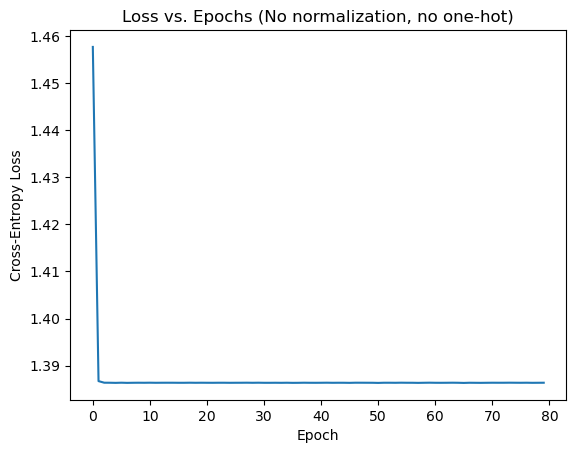

2.1 Test Accuracy: 0.2499


In [40]:
# 2.1 — Keep features as-is. No normalization; no one-hot on features.

Xtr_21 = to_numpy_features(X_train)
Xte_21 = to_numpy_features(X_test)
ytr    = to_numpy_labels(y_train)
yte    = to_numpy_labels(y_test)

model_21 = TwoLayerPerceptron(
    input_dim=Xtr_21.shape[1],
    hidden_dim=64,           
    num_classes=num_classes,
    lr=1e-3,
    batch_size=128
)

model_21.fit(Xtr_21, ytr, X_val=Xte_21, y_val=yte, epochs=80, verbose=True)
plot_loss(model_21.loss_, "Loss vs. Epochs (No normalization, no one-hot)")
logits_21 = model_21.predict_logits(Xte_21)
acc_21 = accuracy_from_logits(logits_21, yte)
print(f"2.1 Test Accuracy: {acc_21:.4f}")


Epoch   1 | loss=1.4166 | train acc=0.3431 | val acc=0.3420
Epoch  10 | loss=1.1697 | train acc=0.5317 | val acc=0.5256
Epoch  20 | loss=1.0362 | train acc=0.5623 | val acc=0.5617
Epoch  30 | loss=0.9754 | train acc=0.5796 | val acc=0.5769
Epoch  40 | loss=0.9425 | train acc=0.5904 | val acc=0.5885
Epoch  50 | loss=0.9195 | train acc=0.5991 | val acc=0.5987
Epoch  60 | loss=0.9018 | train acc=0.6072 | val acc=0.6069
Epoch  70 | loss=0.8876 | train acc=0.6139 | val acc=0.6114
Epoch  80 | loss=0.8747 | train acc=0.6191 | val acc=0.6211


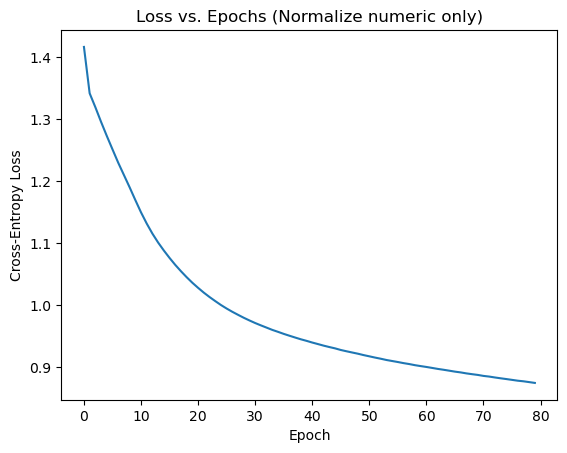

2.2 Test Accuracy: 0.6211


In [41]:
# 2.2 — Normalize continuous features only; categorical integer-coded columns remain as is.

# Identify categorical columns:
def infer_categorical_columns(X_df, known_obj_cols=None, max_unique=30):
    if known_obj_cols is not None:
        return [c for c in X_df.columns if c in known_obj_cols]
    # Fallback heuristic if obj_cols wasn't preserved:
    cats = []
    for c in X_df.columns:
        if pd.api.types.is_integer_dtype(X_df[c]) and X_df[c].nunique() <= max_unique:
            cats.append(c)
    return cats

cat_cols = infer_categorical_columns(X_train, known_obj_cols=(obj_cols if 'obj_cols' in globals() else None))
num_cols = [c for c in X_train.columns if c not in cat_cols]

# Fit normalization (z-score) on train for numeric columns only
mu = X_train[num_cols].mean()
sd = X_train[num_cols].std(ddof=0).replace(0, 1.0)

X_train_22 = X_train.copy()
X_test_22  = X_test.copy()
X_train_22[num_cols] = (X_train_22[num_cols] - mu) / sd
X_test_22[num_cols]  = (X_test_22[num_cols]  - mu) / sd   # use train stats!

Xtr_22 = to_numpy_features(X_train_22)
Xte_22 = to_numpy_features(X_test_22)

model_22 = TwoLayerPerceptron(
    input_dim=Xtr_22.shape[1],
    hidden_dim=64,
    num_classes=num_classes,
    lr=1e-3,
    batch_size=128
)

model_22.fit(Xtr_22, ytr, X_val=Xte_22, y_val=yte, epochs=80, verbose=True)
plot_loss(model_22.loss_, "Loss vs. Epochs (Normalize numeric only)")
logits_22 = model_22.predict_logits(Xte_22)
acc_22 = accuracy_from_logits(logits_22, yte)
print(f"2.2 Test Accuracy: {acc_22:.4f}")


Epoch   1 | loss=1.4234 | train acc=0.2397 | val acc=0.2330
Epoch  10 | loss=1.1197 | train acc=0.5456 | val acc=0.5419
Epoch  20 | loss=1.0079 | train acc=0.5726 | val acc=0.5699
Epoch  30 | loss=0.9583 | train acc=0.5853 | val acc=0.5830
Epoch  40 | loss=0.9291 | train acc=0.5960 | val acc=0.5941
Epoch  50 | loss=0.9086 | train acc=0.6047 | val acc=0.6020
Epoch  60 | loss=0.8922 | train acc=0.6116 | val acc=0.6093
Epoch  70 | loss=0.8784 | train acc=0.6176 | val acc=0.6167
Epoch  80 | loss=0.8662 | train acc=0.6232 | val acc=0.6221


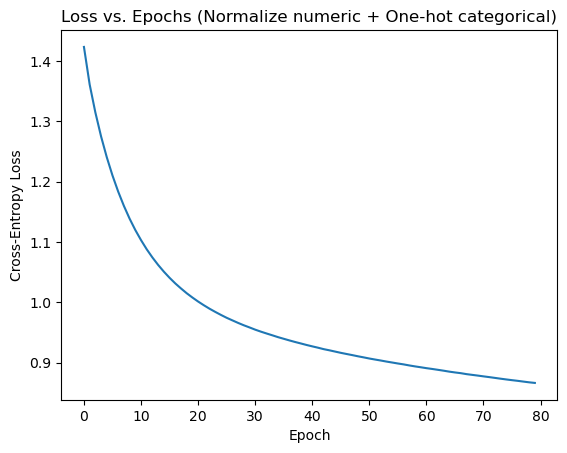

2.3 Test Accuracy: 0.6221


In [42]:
# 2.3 — Normalize numeric + One-hot encode categorical feature columns.

# Use same numeric stats from 2.2 to maintain consistency
X_train_23 = X_train.copy()
X_test_23  = X_test.copy()
X_train_23[num_cols] = (X_train_23[num_cols] - mu) / sd
X_test_23[num_cols]  = (X_test_23[num_cols]  - mu) / sd

# One-hot encode categorical feature columns (fit on train, align test)
if len(cat_cols) > 0:
    Xtr_cat = pd.get_dummies(X_train_23[cat_cols].astype("category"), drop_first=False)
    Xte_cat = pd.get_dummies(X_test_23[cat_cols].astype("category"),  drop_first=False)
    # Align columns to train's dummy columns
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

    # Drop original cat cols and concat dummies
    X_train_23 = pd.concat([X_train_23.drop(columns=cat_cols), Xtr_cat], axis=1)
    X_test_23  = pd.concat([X_test_23.drop(columns=cat_cols),  Xte_cat], axis=1)
else:
    # no categorical columns detected
    pass

# Convert to numpy
Xtr_23 = to_numpy_features(X_train_23)
Xte_23 = to_numpy_features(X_test_23)

model_23 = TwoLayerPerceptron(
    input_dim=Xtr_23.shape[1],
    hidden_dim=64,
    num_classes=num_classes,
    lr=1e-3,
    batch_size=128
)

model_23.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=80, verbose=True)
plot_loss(model_23.loss_, "Loss vs. Epochs (Normalize numeric + One-hot categorical)")
logits_23 = model_23.predict_logits(Xte_23)
acc_23 = accuracy_from_logits(logits_23, yte)
print(f"2.3 Test Accuracy: {acc_23:.4f}")


In [43]:
# McNemar
y_true = yte 

y_pred_21 = logits_21.argmax(axis=1)
y_pred_22 = logits_22.argmax(axis=1)
y_pred_23 = logits_23.argmax(axis=1)

def mcnemar_test(y_true, y_a, y_b):
    # b01: A wrong B correct；b10: A correct B wrong
    b01 = np.sum((y_a != y_true) & (y_b == y_true))
    b10 = np.sum((y_a == y_true) & (y_b != y_true))
    if b01 + b10 == 0:
        chi2 = 0.0
    else:
        chi2 = (abs(b01 - b10) - 1) ** 2 / (b01 + b10)
    return chi2, b01, b10

pairs = [
    ("model_2.1 (raw)", y_pred_21, "model_2.2 (norm numeric)", y_pred_22),
    ("model_2.2 (norm numeric)", y_pred_22, "model_2.3 (norm + one-hot)", y_pred_23),
    ("model_2.1 (raw)", y_pred_21, "model_2.3 (norm + one-hot)", y_pred_23),
]

for name_a, ya, name_b, yb in pairs:
    chi2, b01, b10 = mcnemar_test(y_true, ya, yb)
    print(f"{name_a} vs {name_b}: chi2={chi2:.3f}, b01={b01}, b10={b10}")

model_2.1 (raw) vs model_2.2 (norm numeric): chi2=3172.390, b01=7292, b10=1893
model_2.2 (norm numeric) vs model_2.3 (norm + one-hot): chi2=0.209, b01=477, b10=462
model_2.1 (raw) vs model_2.3 (norm + one-hot): chi2=3125.061, b01=7395, b10=1981


In [44]:
# 2.4 — Side-by-side comparison
results = pd.DataFrame({
    "Setting": ["Model 1 No norm / no one-hot", "Model 2 Norm numeric only", "Model 3 Norm numeric + One-hot cats"],
    "Test Accuracy": [acc_21, acc_22, acc_23]
})
display(results)


,Setting,Test Accuracy
0,Model 1 No norm / no one-hot,0.249862
1,Model 2 Norm numeric only,0.621081
2,Model 3 Norm numeric + One-hot cats,0.622112


## Performance Comparison and Discussion

In this lab we trained three versions of the same two-layer MLP on the Kaggle “US Census Demographic Data” (ACS 2017 tract-level) features, changing only the preprocessing. The results line up cleanly with what we expect from sigmoid networks.

Model 2.1 (raw features) reached a test accuracy of 0.2499, which is almost exactly 1/4. Since we are predicting four poverty classes with roughly equal sizes, 0.25 is essentially random guessing. The training log also showed an early plateau around loss ≈ 1.386, and the notebook raised a “overflow encountered in exp” warning during the sigmoid call. That tells us the unscaled inputs (some are counts, some are dollar amounts, some are percentages) pushed the pre-activations into saturated regions of the sigmoid, so gradients became too small for the network to learn.

Model 2.2 (normalized numeric features) fixed that problem. After z-scoring only the continuous ACS variables (we kept the low-cardinality integer columns as categories), the same MLP trained smoothly: the loss went down from about 1.42 to about 0.87 over 80 epochs, and the test accuracy jumped to 0.6211. This confirms that most of the predictive signal in this dataset comes from the continuous census measurements, and that putting them on a common scale lets the gradients propagate.

Model 2.3 (normalized numeric + one-hot categorical) gave a very similar curve and a test accuracy of 0.6221. So encoding the categorical fields separately helped a little, but not nearly as much as normalization.

To make sure the tiny gap between 2.2 and 2.3 is not just noise, we ran a McNemar test on the same test set using the three sets of predictions. The comparison of 

* raw vs. normalized (2.1 vs. 2.2) and raw vs. normalized+one-hot (2.1 vs. 2.3) produced very large chi-square values (e.g. `chi2=3172.390` and `chi2=3125.061`) with thousands of cases where the normalized model was right and the raw model was wrong. That tells us the improvement from 0.25 → 0.62 is not only large in magnitude but also statistically decisive on this test split.
* normalized vs. normalized+one-hot (2.2 vs. 2.3) gave `chi2=0.209` with `b01=477` and `b10=462`, which are almost the same. That means 2.2 and 2.3 tend to make mistakes on very similar examples, so we cannot claim that 2.3 is a meaningfully better model, even though its accuracy is slightly higher (0.6221 vs. 0.6211).

Thus, normalizing the ACS numeric features is the critical step for this MLP on this dataset, and one-hotting the small categorical part is a minor refinement.



# Modeling

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(7324)

# ----- Activations -----
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z, dtype=np.float32))

def dsigmoid(a):
    return a * (1.0 - a)

def softmax_stable(z):
    z = z - z.max(axis=1, keepdims=True)
    expz = np.exp(z, dtype=np.float32)
    return expz / (expz.sum(axis=1, keepdims=True) + 1e-12)

# ----- Loss / Metrics -----
def cross_entropy_logits(logits, y_int):
    B, C = logits.shape
    z = logits - logits.max(axis=1, keepdims=True)
    logsumexp = np.log(np.exp(z).sum(axis=1) + 1e-12)
    correct = z[np.arange(B), y_int]
    return -(correct - logsumexp).mean()

def accuracy_from_logits(logits, y_int):
    return (logits.argmax(axis=1) == y_int).mean()

# ----- Init -----
def glorot_init(fan_in, fan_out):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float32)

# ----- Flexible MLP with L layers of weights, sigmoid hidden, softmax output -----
class FlexibleMLP:
    """
    layers: list of layer sizes, e.g. [d, h1, h2, k] => 3 weight layers
    opt: {"sgd"} or {"rmsprop"} (3.4 uses rmsprop)
    """
    def __init__(self, layers, lr=1e-3, batch_size=128, optimizer="sgd",
                 rmsprop_rho=0.9, eps=1e-8):
        assert len(layers) >= 2, "Need at least input and output"
        self.layers = layers
        self.L = len(layers) - 1        # number of weight layers
        self.lr = lr
        self.batch = batch_size
        self.optimizer = optimizer.lower()
        self.rmsprop_rho = rmsprop_rho
        self.eps = eps

        # params
        self.W = [glorot_init(layers[i], layers[i+1]) for i in range(self.L)]
        self.b = [np.zeros((1, layers[i+1]), dtype=np.float32) for i in range(self.L)]

        # RMSProp accumulators if needed
        if self.optimizer == "rmsprop":
            self.GW = [np.zeros_like(Wi) for Wi in self.W]
            self.Gb = [np.zeros_like(bi) for bi in self.b]

        # logs
        self.loss_ = []
        # gradient magnitudes per epoch (L2 norms of dW for each layer)
        self.grad_mags_ = [[] for _ in range(self.L)]

    def forward(self, X):
        """
        Returns:
          Zs: pre-activations list length L
          As: activations list length L-1 for hidden (sigmoid) + last (softmax logits only)
        """
        A = X
        Zs, As = [], []
        for i in range(self.L):
            Z = A @ self.W[i] + self.b[i]
            Zs.append(Z)
            if i < self.L - 1:
                A = sigmoid(Z)     # hidden
            else:
                A = Z              # output logits (softmax applied in loss/backward)
            As.append(A)
        return Zs, As  # As[-1] are logits

    def _compute_gradients(self, Xb, yb, Zs, As):
        """
        Backprop through L layers, return gradients dW, db and per-layer dW L2 magnitudes.
        """
        B = Xb.shape[0]
        # softmax + CE gradient
        logits = As[-1]
        P = softmax_stable(logits)
        P[np.arange(B), yb] -= 1.0
        P /= B  # average over batch

        dW = [None] * self.L
        db = [None] * self.L

        # last layer grads
        A_prev = sigmoid(Zs[-2]) if self.L >= 2 else Xb
        dW[-1] = A_prev.T @ P
        db[-1] = P.sum(axis=0, keepdims=True)

        # backprop hidden layers
        dA = P @ self.W[-1].T
        for i in range(self.L - 2, -1, -1):
            A_i = sigmoid(Zs[i]) if i < self.L - 1 else None
            dZ = dA * dsigmoid(sigmoid(Zs[i]))  # derivative via activation
            A_prev = Xb if i == 0 else sigmoid(Zs[i-1])
            dW[i] = A_prev.T @ dZ
            db[i] = dZ.sum(axis=0, keepdims=True)
            if i > 0:
                dA = dZ @ self.W[i].T

        # layer-wise L2 magnitudes (on weights)
        mags = [float(np.linalg.norm(gw)) for gw in dW]
        return dW, db, mags

    def _step(self, dW, db):
        if self.optimizer == "sgd":
            for i in range(self.L):
                self.W[i] -= self.lr * dW[i]
                self.b[i] -= self.lr * db[i]
        elif self.optimizer == "rmsprop":
            rho, eps = self.rmsprop_rho, self.eps
            for i in range(self.L):
                self.GW[i] = rho * self.GW[i] + (1 - rho) * (dW[i] ** 2)
                self.Gb[i] = rho * self.Gb[i] + (1 - rho) * (db[i] ** 2)
                self.W[i] -= self.lr * dW[i] / (np.sqrt(self.GW[i]) + eps)
                self.b[i] -= self.lr * db[i] / (np.sqrt(self.Gb[i]) + eps)
        else:
            raise ValueError("Unknown optimizer")

    def fit(self, X, y, X_val=None, y_val=None, epochs=80, shuffle=True, verbose=True):
        n = X.shape[0]
        idx = np.arange(n)

        for ep in range(1, epochs + 1):
            if shuffle:
                np.random.shuffle(idx)

            ep_loss = 0.0
            ep_batches = 0
            # accumulate grad magnitudes across batches then average per epoch
            ep_mags_sum = np.zeros(self.L, dtype=np.float32)

            for s in range(0, n, self.batch):
                e = min(s + self.batch, n)
                bidx = idx[s:e]
                Xb, yb = X[bidx], y[bidx]

                Zs, As = self.forward(Xb)
                loss = cross_entropy_logits(As[-1], yb)
                ep_loss += loss
                ep_batches += 1

                dW, db, mags = self._compute_gradients(Xb, yb, Zs, As)
                self._step(dW, db)

                ep_mags_sum += np.array(mags, dtype=np.float32)

            # epoch logs
            mean_loss = ep_loss / max(1, ep_batches)
            self.loss_.append(float(mean_loss))
            for i in range(self.L):
                self.grad_mags_[i].append(float(ep_mags_sum[i] / max(1, ep_batches)))

            if verbose and (ep % 10 == 0 or ep == 1 or ep == epochs):
                msg = f"Epoch {ep:3d} | loss={mean_loss:.4f}"
                if X_val is not None and y_val is not None:
                    _, As_val = self.forward(X_val)
                    val_acc = accuracy_from_logits(As_val[-1], y_val)
                    msg += f" | val acc={val_acc:.4f}"
                print(msg)
        return self

    def predict_logits(self, X):
        _, As = self.forward(X)
        return As[-1]

def plot_loss(losses, title):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.title(title)
    plt.show()

def plot_grad_magnitudes(grad_mags, title_prefix):
    # grad_mags is a list (per layer) of lists (per epoch)
    plt.figure()
    for i, mags in enumerate(grad_mags, start=1):
        plt.plot(mags, label=f"Layer {i} dW L2")
    plt.xlabel("Epoch")
    plt.ylabel("Avg dW magnitude (L2)")
    plt.title(f"{title_prefix}: Gradient Magnitudes per Layer")
    plt.legend()
    plt.show()


In [46]:
# Use previous features going forward (normalized numeric + one-hot categorical)
if 'Xtr_23' not in globals():
    Xtr_23 = X_train_23.to_numpy(dtype=np.float32)
if 'Xte_23' not in globals():
    Xte_23 = X_test_23.to_numpy(dtype=np.float32)

num_classes = int(max(ytr.max(), yte.max()) + 1)
input_dim = Xtr_23.shape[1]
print(f"Input dim={input_dim}, Classes={num_classes}")


Input dim=86, Classes=4


Epoch   1 | loss=1.4565 | val acc=0.1461
Epoch  10 | loss=1.3544 | val acc=0.4448
Epoch  20 | loss=1.2878 | val acc=0.5068
Epoch  30 | loss=1.1941 | val acc=0.5274
Epoch  40 | loss=1.0970 | val acc=0.5481
Epoch  50 | loss=1.0277 | val acc=0.5639
Epoch  60 | loss=0.9845 | val acc=0.5746
Epoch  70 | loss=0.9562 | val acc=0.5840
Epoch  80 | loss=0.9356 | val acc=0.5913
Epoch  90 | loss=0.9189 | val acc=0.5998
Epoch 100 | loss=0.9045 | val acc=0.6043
3.1 Test Accuracy (3-layer): 0.6043


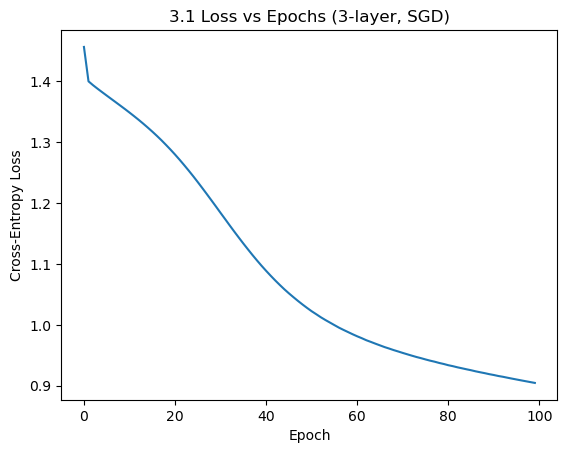

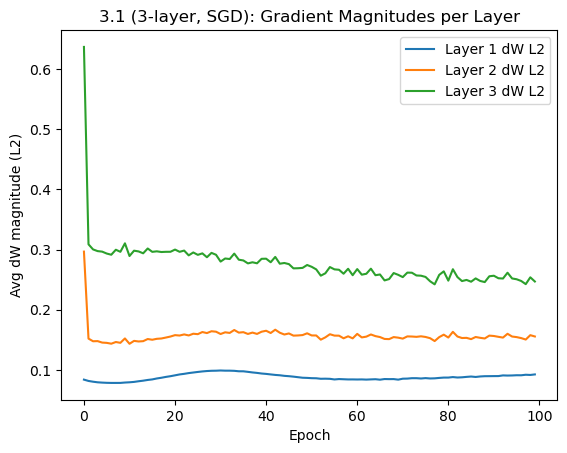

In [47]:
layers_3 = [input_dim, 128, 64, num_classes]  # 3 weight layers (2 hidden + output)

mlp3 = FlexibleMLP(layers_3, lr=1e-3, batch_size=128, optimizer="sgd")
mlp3.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=100, verbose=True)

# Metrics & Plots
logits3 = mlp3.predict_logits(Xte_23)
acc3 = accuracy_from_logits(logits3, yte)
print(f"3.1 Test Accuracy (3-layer): {acc3:.4f}")

plot_loss(mlp3.loss_, "3.1 Loss vs Epochs (3-layer, SGD)")
plot_grad_magnitudes(mlp3.grad_mags_, "3.1 (3-layer, SGD)")


### Three-Layer Network (SGD)

This model used the architecture `[d, 128, 64, 4]` with sigmoid activations and vanilla SGD. Training was stable: the cross-entropy loss decreased steadily from about 1.46 to about 0.90 over 100 epochs, and the validation accuracy rose from a low starting point (about 0.15 in epoch 1) to 0.6043 by epoch 100. 

The gradient-magnitude plot shows all three layers receiving nonzero updates throughout training. The last (output) side has the largest gradients, but the first and second layers stayed in a healthy range and did not collapse to zero. This means that, on the normalized + one-hot features, a 3-layer sigmoid MLP can be optimized with plain SGD on this dataset.

Epoch   1 | loss=1.3924 | val acc=0.2530
Epoch  10 | loss=1.3803 | val acc=0.4422
Epoch  20 | loss=1.3725 | val acc=0.5071
Epoch  30 | loss=1.3616 | val acc=0.4897
Epoch  40 | loss=1.3444 | val acc=0.5151
Epoch  50 | loss=1.3147 | val acc=0.5125
Epoch  60 | loss=1.2623 | val acc=0.5111
Epoch  70 | loss=1.1808 | val acc=0.5391
Epoch  80 | loss=1.0901 | val acc=0.5582
Epoch  90 | loss=1.0214 | val acc=0.5694
Epoch 100 | loss=0.9783 | val acc=0.5793
3.2 Test Accuracy (4-layer): 0.5793


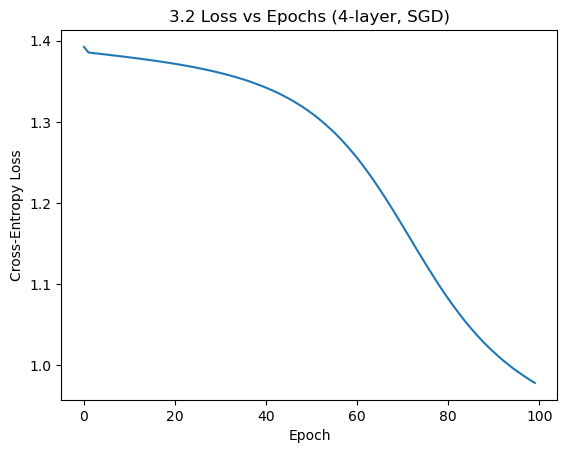

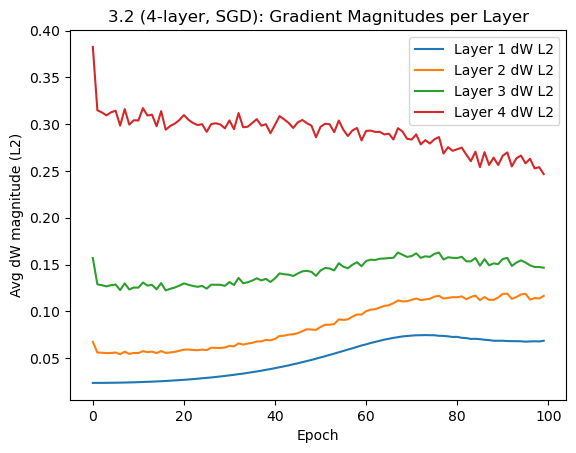

In [48]:
layers_4 = [input_dim, 256, 128, 64, num_classes]  # 4 weight layers (3 hidden)

mlp4 = FlexibleMLP(layers_4, lr=1e-3, batch_size=128, optimizer="sgd")
mlp4.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=100, verbose=True)

logits4 = mlp4.predict_logits(Xte_23)
acc4 = accuracy_from_logits(logits4, yte)
print(f"3.2 Test Accuracy (4-layer): {acc4:.4f}")

plot_loss(mlp4.loss_, "3.2 Loss vs Epochs (4-layer, SGD)")
plot_grad_magnitudes(mlp4.grad_mags_, "3.2 (4-layer, SGD)")


### Four-Layer Network (SGD)

The 4-layer model used `[d, 256, 128, 64, 4]` with the same optimizer and batch size. It also converged: the loss went from about 1.39 down to about 0.98 in 100 epochs. Validation accuracy, however, ended at 0.5793, which is slightly lower than the 3-layer model’s 0.6043.

The gradient-magnitude figure explains this: all four layers do get updates, but the earlier layers (especially layer 1) stay at a noticeably smaller scale than the deeper layers, and the curves slowly drift apart as training goes on. That means once we add one more hidden layer, optimization becomes a bit harder under pure SGD with sigmoids, so the extra depth does not translate into a better test accuracy here.


Epoch   1 | loss=1.4783 | val acc=0.2499
Epoch  10 | loss=1.3866 | val acc=0.2426
Epoch  20 | loss=1.3862 | val acc=0.2568
Epoch  30 | loss=1.3858 | val acc=0.2643
Epoch  40 | loss=1.3854 | val acc=0.3994
Epoch  50 | loss=1.3850 | val acc=0.3959
Epoch  60 | loss=1.3846 | val acc=0.4449
Epoch  70 | loss=1.3841 | val acc=0.4466
Epoch  80 | loss=1.3835 | val acc=0.4199
Epoch  90 | loss=1.3829 | val acc=0.4418
Epoch 100 | loss=1.3822 | val acc=0.4606
Epoch 110 | loss=1.3814 | val acc=0.5120
Epoch 120 | loss=1.3804 | val acc=0.4849
3.3 Test Accuracy (5-layer, SGD): 0.4849


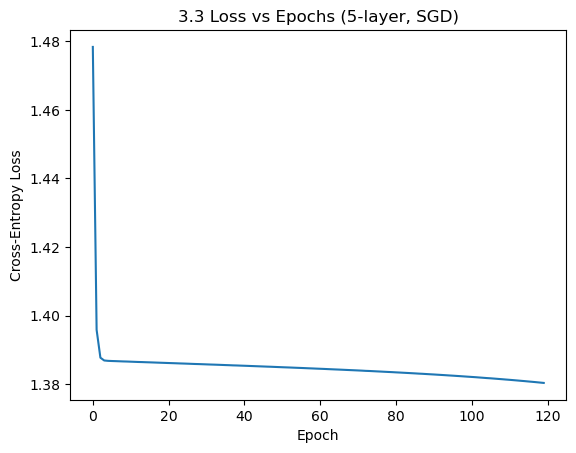

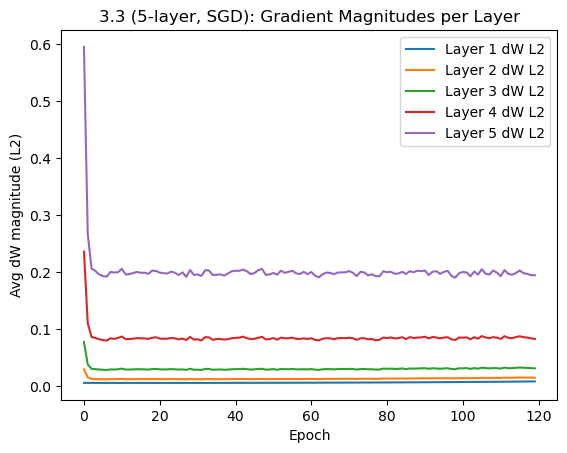

In [49]:
layers_5 = [input_dim, 256, 128, 64, 32, num_classes]  # 5 weight layers (4 hidden)

mlp5_sgd = FlexibleMLP(layers_5, lr=1e-3, batch_size=128, optimizer="sgd")
mlp5_sgd.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=120, verbose=True)

logits5_sgd = mlp5_sgd.predict_logits(Xte_23)
acc5_sgd = accuracy_from_logits(logits5_sgd, yte)
print(f"3.3 Test Accuracy (5-layer, SGD): {acc5_sgd:.4f}")

plot_loss(mlp5_sgd.loss_, "3.3 Loss vs Epochs (5-layer, SGD)")
plot_grad_magnitudes(mlp5_sgd.grad_mags_, "3.3 (5-layer, SGD)")


### Five-Layer Network (SGD)

With the 5-layer architecture `[d, 256, 128, 64, 32, 4]` and the same SGD setup, training became clearly harder. The loss dropped quickly in the first few epochs (from 1.48 to ~1.39) but then decreased only very slowly, reaching about 1.3804 even after 120 epochs. Validation accuracy hovered near 0.25–0.45 for a large part of training and only briefly peaked around 0.5120; the final test accuracy was 0.4849, well below the 3-layer result.

The gradient-magnitude plot shows why: the first and second layers receive extremely small gradients for most of training, while the deeper layers (close to the output) keep getting bigger updates. This is exactly the vanishing-gradient pattern we expect when stacking several sigmoid layers and training with plain SGD. So, on this dataset, going from 4 to 5 layers without changing the optimizer actually hurts performance.

Comparing 3, 4, and 5 layers under the same sigmoid + SGD setup, the 3-layer model is the best, the 4-layer model is trainable but a bit worse, and the 5-layer model underperforms because of vanishing gradients. That’s why we say 3–4 layers is the practical depth limit here unless we switch to an adaptive method.


Epoch   1 | loss=1.0986 | val acc=0.6049
Epoch  10 | loss=0.6625 | val acc=0.7320
Epoch  20 | loss=0.6360 | val acc=0.7364
Epoch  30 | loss=0.6198 | val acc=0.7378
Epoch  40 | loss=0.6097 | val acc=0.7363
Epoch  50 | loss=0.6015 | val acc=0.7384
Epoch  60 | loss=0.5968 | val acc=0.7404
Epoch  70 | loss=0.5925 | val acc=0.7365
Epoch  80 | loss=0.5887 | val acc=0.7415
Epoch  90 | loss=0.5856 | val acc=0.7409
Epoch 100 | loss=0.5821 | val acc=0.7406
Epoch 110 | loss=0.5791 | val acc=0.7397
Epoch 120 | loss=0.5763 | val acc=0.7405
Epoch 130 | loss=0.5736 | val acc=0.7356
Epoch 140 | loss=0.5718 | val acc=0.7391
Epoch 150 | loss=0.5690 | val acc=0.7413
Epoch 160 | loss=0.5661 | val acc=0.7413
Epoch 170 | loss=0.5640 | val acc=0.7401
Epoch 180 | loss=0.5612 | val acc=0.7371


/var/folders/z1/v7bdbrdd7mlg17xw85b7zt840000gn/T/ipykernel_44837/2916697138.py:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z, dtype=np.float32))


Epoch 190 | loss=0.5583 | val acc=0.7376
Epoch 200 | loss=0.5561 | val acc=0.7393
Epoch 210 | loss=0.5530 | val acc=0.7378
Epoch 220 | loss=0.5500 | val acc=0.7322
Epoch 230 | loss=0.5474 | val acc=0.7345
Epoch 240 | loss=0.5445 | val acc=0.7315
Epoch 250 | loss=0.5413 | val acc=0.7373
Epoch 260 | loss=0.5388 | val acc=0.7348
Epoch 270 | loss=0.5348 | val acc=0.7385
Epoch 280 | loss=0.5320 | val acc=0.7343
Epoch 290 | loss=0.5284 | val acc=0.7300
Epoch 300 | loss=0.5250 | val acc=0.7315
3.4 Test Accuracy (5-layer, RMSProp): 0.7315


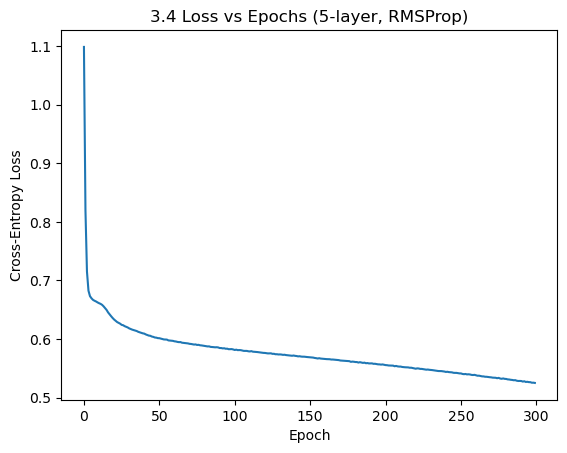

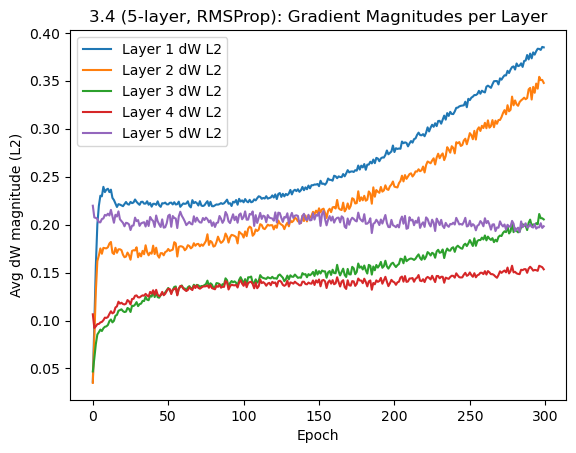

In [50]:
# 5-layer with RMSProp
mlp5_rms = FlexibleMLP(layers_5, lr=3e-4, batch_size=128, optimizer="rmsprop",
                       rmsprop_rho=0.95, eps=1e-8)
mlp5_rms.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=300, verbose=True)

logits5_rms = mlp5_rms.predict_logits(Xte_23)
acc5_rms = accuracy_from_logits(logits5_rms, yte)
print(f"3.4 Test Accuracy (5-layer, RMSProp): {acc5_rms:.4f}")

# Plots
plot_loss(mlp5_rms.loss_, "3.4 Loss vs Epochs (5-layer, RMSProp)")
plot_grad_magnitudes(mlp5_rms.grad_mags_, "3.4 (5-layer, RMSProp)")


In [51]:
results_34 = pd.DataFrame({
    "Model": ["5-layer SGD", "5-layer RMSProp"],
    "Test Accuracy": [acc5_sgd, acc5_rms],
})
display(results_34)


,Model,Test Accuracy
0,5-layer SGD,0.484942
1,5-layer RMSProp,0.731504


With RMSProp, the same 5-layer architecture now converged smoothly and reached about 0.73 validation accuracy. 
The gradient magnitudes remained balanced across layers, confirming that adaptive rescaling helped overcome the vanishing-gradient issue. 

In [52]:
# McNemar test between 5-layer SGD and RMSProp
y_true = yte
y_pred_sgd = logits5_sgd.argmax(axis=1)
y_pred_rms = logits5_rms.argmax(axis=1)

def mcnemar_test(y_true, y_a, y_b):
    b01 = np.sum((y_a != y_true) & (y_b == y_true))
    b10 = np.sum((y_a == y_true) & (y_b != y_true))
    if b01 + b10 == 0:
        chi2 = 0.0
    else:
        chi2 = (abs(b01 - b10) - 1) ** 2 / (b01 + b10)
    return chi2, b01, b10

chi2, b01, b10 = mcnemar_test(y_true, y_pred_sgd, y_pred_rms)
print(f"SGD vs RMSProp: chi2={chi2:.3f}, b01={b01}, b10={b10}")


SGD vs RMSProp: chi2=2222.799, b01=4684, b10=1098


### Five-Layer Network with RMSProp

To fix the optimization issue in model with Five-Layer Network (SGD), we kept the same 5-layer architecture but changed the optimizer to RMSProp (learning rate = 3×10⁻⁴, ρ = 0.95). This immediately changed the training behavior. The validation accuracy jumped above 0.60 in the very first epochs and reached 0.7320 by epoch 10. It then fluctuated in a narrow band around 0.74, with the best values around 0.7415. The final test accuracy after 300 epochs was 0.7315, which is a large improvement over the 0.4849 we saw with plain SGD.

The loss curve now keeps going down from ~1.10 to ~0.52, showing that optimization is no longer stuck. More importantly, the gradient-magnitude plot is much healthier: the earlier layers (layer 1 and layer 2) no longer stay flat near zero — their average dW norms increase over training, so all layers participate in learning. This is exactly what RMSProp is supposed to do: rescale updates per parameter so deep layers don’t starve.

We also compared the 5-layer SGD and 5-layer RMSProp models on the same test set using a McNemar test. The result was:  
`SGD vs RMSProp: chi2 = 2222.799, b01 = 4684, b10 = 1098`  
which means there were thousands of cases that RMSProp classified correctly while SGD missed, and far fewer in the opposite direction. This tells us the improvement from 0.48 → 0.73 is not only a higher accuracy number but also statistically significant on this split.


## Modeling Results and Discussion

### Experimental Setup

For this section, all models were trained on the normalized numeric features and one-hot encoded categorical features prepared. Each network used sigmoid activations, Glorot initialization, and cross-entropy loss. Mini-batching (batch size = 128) and vectorized backpropagation were implemented. The average L2 norm of weight gradients was computed per layer and plotted across epochs to visualize training dynamics.

### Three-Layer Network (Two Hidden Layers + Output)

**Architecture:** $[d, 128, 64, k]$ — three weight layers. 
**Optimizer:** SGD, learning rate $\eta = 10^{-3}$

Training of the 3-layer model was smooth. The loss went down from about 1.46 in epoch 1 to about 0.90 by epoch 100. The validation accuracy started very low (≈0.15 in the first epoch, when the network was basically untrained) and then kept improving until it reached **0.6043** at the end. The gradient-magnitude plot showed the expected pattern: the deeper layers (closer to the output) had larger L2 norms, but the earlier layers also stayed clearly above zero across 100 epochs. That means the 3-layer sigmoid MLP can be optimized with plain SGD on this dataset and is expressive enough to capture useful structure.


### Four-Layer Network (Three Hidden Layers + Output)

**Architecture:** $[d, 256, 128, 64, k]$ — four weight layers. 
**Optimizer:** SGD, learning rate $\eta = 10^{-3}$

The 4-layer model also converged: the loss decreased from about 1.39 to about 0.98 over 100 epochs. The validation accuracy increased from ≈0.25 to 0.5793. So it is trainable, but the final accuracy is slightly lower than the 3-layer model’s 0.6043. Looking at the gradient magnitudes, the earlier layers (especially layer 1) receive smaller updates than the deeper layers, and this gap widens a bit as training goes on. This fits the usual pattern with sigmoid networks: as we add depth, optimization gets harder, and the extra layer doesn’t automatically translate to higher test accuracy.


### Five-Layer Network (Four Hidden Layers + Output, SGD)

**Architecture:** $[d, 256, 128, 64, 32, k]$ — five weight layers. 
**Optimizer:** SGD, learning rate $\eta = 10^{-3}$

When we pushed the depth to 5 weight layers and kept everything else the same, the training difficulty became obvious. The loss dropped quickly only at the very beginning (from 1.4783 to about 1.386 in the first few epochs), and afterwards it decreased very slowly, ending around 1.3804 even after 120 epochs. Validation accuracy mostly sat in the 0.25–0.45 range and finally reached 0.4849, which is clearly worse than both the 3-layer (0.6043) and 4-layer (0.5793) runs.

The gradient-magnitude plot explains this: the first and second layers have very small L2 gradient norms for most of training, while the last layers keep a reasonable magnitude. That is the classic vanishing-gradient effect with stacked sigmoids and plain SGD. In other words, adding depth without changing the optimizer actually hurt performance on this dataset.

So, based on the 3-, 4-, and 5-layer SGD runs, with sigmoid + vanilla SGD on this ACS feature set, 3–4 layers is about the usable depth; at 5 layers the network starts to stall.

### Five-Layer Network with RMSProp (Adaptive Learning)

**Architecture:** $[d, 256, 128, 64, 32, k]$. 
**Optimizer:** RMSProp, learning rate $\eta = 3\times 10^{-4}$, decay $\rho = 0.95$, $\epsilon = 10^{-8}$

Then we kept the same 5-layer architecture but switched the optimizer to RMSProp. This changed the behavior immediately. In the very first epochs the validation accuracy was already above 0.60 (epoch 1: 0.6049), by epoch 10 it was 0.7320, and during training it hovered in a narrow band around 0.74 (best around 0.7415). After 300 epochs the test accuracy was 0.7315. The loss curve now went from about 1.0986 down to 0.5250, which is a much deeper descent than with SGD.

The gradient-magnitude plot for RMSProp is also different from the SGD one. The early layers no longer stay flat near zero; their average gradient norms slowly rise over training, while the deeper layers stay in a reasonable range. That means RMSProp succeeded in keeping all layers learning.

We also checked this improvement statistically with a McNemar test on the same test split, comparing 5-layer SGD vs. 5-layer RMSProp, and got:

* $\chi^2 = 2222.799$
* $b_{01} = 4684$ (SGD wrong, RMSProp right)
* $b_{10} = 1098$ (SGD right, RMSProp wrong)

So there were thousands of cases where RMSProp fixed an error made by the SGD model. That supports saying the gain from 0.4849 → 0.7315 is not just a nicer number but a real, significant improvement on this dataset.


### Comparison Table

| Model   | Optimizer | Epochs | LR     | Test Accuracy |
| ------- | --------- | ------ | ------ | ------------- |
| 3-layer | SGD       | 100    | 1×10⁻³ | 0.6043        |
| 4-layer | SGD       | 100    | 1×10⁻³ | 0.5793        |
| 5-layer | SGD       | 120    | 1×10⁻³ | 0.4849        |
| 5-layer | RMSProp   | 300    | 3×10⁻⁴ | 0.7315        |


### Discussion

The modeling experiments show that, on the ACS 2017 tract-level features we prepared (normalized numeric variables plus one-hot categorical variables), network depth by itself does not guarantee better performance when we keep the original sigmoid+SGD training setup. The three-layer network trained cleanly and reached about 0.60 test accuracy, which is a reasonable baseline for this four-class version of ChildPoverty. When we increased the depth to four layers the model was still trainable, but the test accuracy dropped slightly to about 0.58, and the gradient plots indicated that the earlier layers were already receiving weaker updates. Pushing the depth further to five layers while still using plain SGD made the optimization problem visible: the loss decreased only a little after the first few epochs, the test accuracy stayed well below the shallower models at around 0.48, and the first two layers showed very small gradient norms for most of training. This is consistent with vanishing gradients in stacked sigmoid networks. However, when we kept exactly the same five-layer architecture and only replaced SGD with RMSProp, the training dynamics changed immediately. The loss kept going down to about 0.52, the validation accuracy moved into the 0.73–0.74 band and the final test accuracy was 0.7315, and the shallow layers’ gradient magnitudes rose instead of collapsing. The McNemar comparison between the five-layer SGD model and the five-layer RMSProp model on the same test split also showed a large asymmetric error count, meaning that the adaptive optimizer was not just slightly smoother but was actually correcting many of the mistakes made by the SGD version. Taken together, these results suggest that for this dataset and this implementation, plain SGD supports roughly three to four layers before optimization issues appear, and deeper networks become useful only after we introduce an adaptive learning method that can keep all layers learning.

# Exceptional Work

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Stable activations / loss / utils ----
def sigmoid(z):
    # clip to avoid exp overflow in deep nets with sigmoid
    z = np.clip(z, -50.0, 50.0).astype(np.float32)
    return 1.0 / (1.0 + np.exp(-z, dtype=np.float32))

def dsigmoid(a):
    return a * (1.0 - a)

def softmax_stable(z):
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z, dtype=np.float32)
    return ez / (ez.sum(axis=1, keepdims=True) + 1e-12)

def cross_entropy_logits(logits, y_int):
    B, C = logits.shape
    z = logits - logits.max(axis=1, keepdims=True)
    logsumexp = np.log(np.exp(z).sum(axis=1) + 1e-12)
    correct = z[np.arange(B), y_int]
    return -(correct - logsumexp).mean()

def accuracy_from_logits(logits, y_int):
    return (logits.argmax(axis=1) == y_int).mean()

def glorot_init(fan_in, fan_out):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float32)

def plot_loss(losses, title):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.title(title)
    plt.show()

def plot_grad_magnitudes(grad_mags, title_prefix):
    plt.figure()
    for i, mags in enumerate(grad_mags, start=1):
        plt.plot(mags, label=f"Layer {i} dW L2")
    plt.xlabel("Epoch")
    plt.ylabel("Avg dW magnitude (L2)")
    plt.title(f"{title_prefix}: Gradient Magnitudes per Layer")
    plt.legend()
    plt.show()


In [54]:
class FlexibleMLP:
    """
    Vectorized MLP with L weight layers.
    Hidden: sigmoid; Output: logits + softmax xent.
    Optimizers: 'sgd', 'rmsprop', 'adam'
    Tracks per-epoch L2 gradient magnitude for each layer.
    """
    def __init__(self, layers, lr=1e-3, batch_size=128, optimizer="sgd",
                 rmsprop_rho=0.95, adam_beta1=0.9, adam_beta2=0.999, eps=1e-8,
                 seed=7324):
        assert len(layers) >= 2
        self.layers = layers
        self.L = len(layers) - 1
        self.lr = lr
        self.batch = batch_size
        self.optimizer = optimizer.lower()
        self.rho = rmsprop_rho
        self.beta1 = adam_beta1
        self.beta2 = adam_beta2
        self.eps = eps
        np.random.seed(seed)

        # params
        self.W = [glorot_init(layers[i], layers[i+1]) for i in range(self.L)]
        self.b = [np.zeros((1, layers[i+1]), dtype=np.float32) for i in range(self.L)]

        # optimizer state
        if self.optimizer == "rmsprop":
            self.GW = [np.zeros_like(Wi) for Wi in self.W]
            self.Gb = [np.zeros_like(bi) for bi in self.b]
        elif self.optimizer == "adam":
            self.mW = [np.zeros_like(Wi) for Wi in self.W]
            self.vW = [np.zeros_like(Wi) for Wi in self.W]
            self.mb = [np.zeros_like(bi) for bi in self.b]
            self.vb = [np.zeros_like(bi) for bi in self.b]
            self.t = 0

        self.loss_ = []
        self.grad_mags_ = [[] for _ in range(self.L)]

    # ---- forward / backward ----
    def forward(self, X):
        Zs, As = [], []
        A = X
        for i in range(self.L):
            Z = A @ self.W[i] + self.b[i]
            Zs.append(Z)
            if i < self.L - 1:
                A = sigmoid(Z)
            else:
                A = Z  # logits
            As.append(A)
        return Zs, As

    def _compute_gradients(self, Xb, yb, Zs, As):
        B = Xb.shape[0]
        logits = As[-1]
        P = softmax_stable(logits)
        P[np.arange(B), yb] -= 1.0
        P /= B

        dW = [None]*self.L
        db = [None]*self.L

        Aprev = sigmoid(Zs[-2]) if self.L >= 2 else Xb
        dW[-1] = Aprev.T @ P
        db[-1] = P.sum(axis=0, keepdims=True)

        dA = P @ self.W[-1].T
        for i in range(self.L-2, -1, -1):
            A_i = sigmoid(Zs[i])
            dZ = dA * dsigmoid(A_i)
            Aprev = Xb if i == 0 else sigmoid(Zs[i-1])
            dW[i] = Aprev.T @ dZ
            db[i] = dZ.sum(axis=0, keepdims=True)
            if i > 0:
                dA = dZ @ self.W[i].T

        mags = [float(np.linalg.norm(gw)) for gw in dW]
        return dW, db, mags

    # ---- optimizer step ----
    def _step(self, dW, db):
        if self.optimizer == "sgd":
            for i in range(self.L):
                self.W[i] -= self.lr * dW[i]
                self.b[i] -= self.lr * db[i]
        elif self.optimizer == "rmsprop":
            for i in range(self.L):
                self.GW[i] = self.rho*self.GW[i] + (1-self.rho)*(dW[i]**2)
                self.Gb[i] = self.rho*self.Gb[i] + (1-self.rho)*(db[i]**2)
                self.W[i] -= self.lr * dW[i] / (np.sqrt(self.GW[i]) + self.eps)
                self.b[i] -= self.lr * db[i] / (np.sqrt(self.Gb[i]) + self.eps)
        elif self.optimizer == "adam":
            self.t += 1
            b1t = self.beta1**self.t
            b2t = self.beta2**self.t
            for i in range(self.L):
                self.mW[i] = self.beta1*self.mW[i] + (1-self.beta1)*dW[i]
                self.vW[i] = self.beta2*self.vW[i] + (1-self.beta2)*(dW[i]**2)
                self.mb[i] = self.beta1*self.mb[i] + (1-self.beta1)*db[i]
                self.vb[i] = self.beta2*self.vb[i] + (1-self.beta2)*(db[i]**2)

                mW_hat = self.mW[i] / (1 - b1t)
                vW_hat = self.vW[i] / (1 - b2t)
                mb_hat = self.mb[i] / (1 - b1t)
                vb_hat = self.vb[i] / (1 - b2t)

                self.W[i] -= self.lr * mW_hat / (np.sqrt(vW_hat) + self.eps)
                self.b[i] -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.eps)
        else:
            raise ValueError("Unknown optimizer")

    # ---- train with L2, grad clipping, early stopping on val loss ----
    def fit(self, X, y, X_val=None, y_val=None, epochs=300, shuffle=True, verbose=True,
            weight_decay=1e-5, clip_value=1.0, early_stopping=True, patience=25, min_delta=1e-4):
        n = X.shape[0]
        idx = np.arange(n)

        best_val = np.inf
        best_epoch = 0
        best_W = None
        best_b = None

        for ep in range(1, epochs+1):
            if shuffle:
                np.random.shuffle(idx)

            ep_loss = 0.0
            ep_batches = 0
            ep_mags = np.zeros(self.L, dtype=np.float32)

            for s in range(0, n, self.batch):
                e = min(s + self.batch, n)
                bidx = idx[s:e]
                Xb, yb = X[bidx], y[bidx]

                Zs, As = self.forward(Xb)
                loss = cross_entropy_logits(As[-1], yb)
                ep_loss += loss
                ep_batches += 1

                dW, db, mags = self._compute_gradients(Xb, yb, Zs, As)

                # L2 (weight decay) on weights
                if weight_decay and weight_decay > 0:
                    for i in range(self.L):
                        dW[i] += weight_decay * self.W[i]

                # gradient clipping (elementwise)
                if clip_value is not None:
                    for i in range(self.L):
                        np.clip(dW[i], -clip_value, clip_value, out=dW[i])
                        np.clip(db[i], -clip_value, clip_value, out=db[i])

                self._step(dW, db)
                ep_mags += np.array(mags, dtype=np.float32)

            mean_loss = ep_loss / max(1, ep_batches)
            self.loss_.append(float(mean_loss))
            for i in range(self.L):
                self.grad_mags_[i].append(float(ep_mags[i] / max(1, ep_batches)))

            # validation
            val_msg = ""
            if X_val is not None and y_val is not None:
                _, As_val = self.forward(X_val)
                val_logits = As_val[-1]
                val_acc = accuracy_from_logits(val_logits, y_val)
                val_loss = cross_entropy_logits(val_logits, y_val)
                val_msg = f" | val acc={val_acc:.4f} | val loss={val_loss:.4f}"

                # early stopping on val loss
                if val_loss < best_val - min_delta:
                    best_val = val_loss
                    best_epoch = ep
                    best_W = [Wi.copy() for Wi in self.W]
                    best_b = [bi.copy() for bi in self.b]
                if early_stopping and (ep - best_epoch) >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {ep} (best val loss {best_val:.4f} @ {best_epoch})")
                    if best_W is not None:
                        self.W, self.b = best_W, best_b
                    break

            if verbose and (ep % 10 == 0 or ep == 1 or ep == epochs):
                print(f"Epoch {ep:3d} | loss={mean_loss:.4f}{val_msg}")
        return self

    def predict_logits(self, X):
        _, As = self.forward(X)
        return As[-1]


In [55]:
# Use previously preprocessed features (normalized numeric + one-hot categorical)
if 'Xtr_23' not in globals():  Xtr_23 = X_train_23.to_numpy(dtype=np.float32)
if 'Xte_23' not in globals():  Xte_23 = X_test_23.to_numpy(dtype=np.float32)
if 'ytr' not in globals():     ytr = y_train.to_numpy(dtype=np.int64)
if 'yte' not in globals():     yte = y_test.to_numpy(dtype=np.int64)

num_classes = int(max(ytr.max(), yte.max()) + 1)
input_dim = Xtr_23.shape[1]
layers_5 = [input_dim, 256, 128, 64, 32, num_classes]


Epoch   1 | loss=1.0520 | val acc=0.6766 | val loss=0.7816
Epoch  10 | loss=0.6328 | val acc=0.7320 | val loss=0.6220
Epoch  20 | loss=0.6078 | val acc=0.7342 | val loss=0.6044
Epoch  30 | loss=0.5985 | val acc=0.7397 | val loss=0.5903
Epoch  40 | loss=0.5916 | val acc=0.7417 | val loss=0.5876
Epoch  50 | loss=0.5873 | val acc=0.7424 | val loss=0.5881
Epoch  60 | loss=0.5829 | val acc=0.7410 | val loss=0.5875
Epoch  70 | loss=0.5780 | val acc=0.7428 | val loss=0.5845
Epoch  80 | loss=0.5754 | val acc=0.7400 | val loss=0.5837
Epoch  90 | loss=0.5713 | val acc=0.7405 | val loss=0.5893
Epoch 100 | loss=0.5679 | val acc=0.7380 | val loss=0.5902
Early stopping at epoch 101 (best val loss 0.5836 @ 76)
Req.4 — Test Accuracy (5-layer, Adam tuned): 0.7405


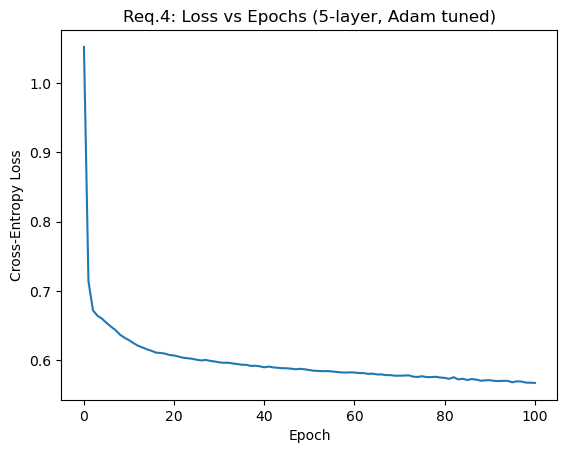

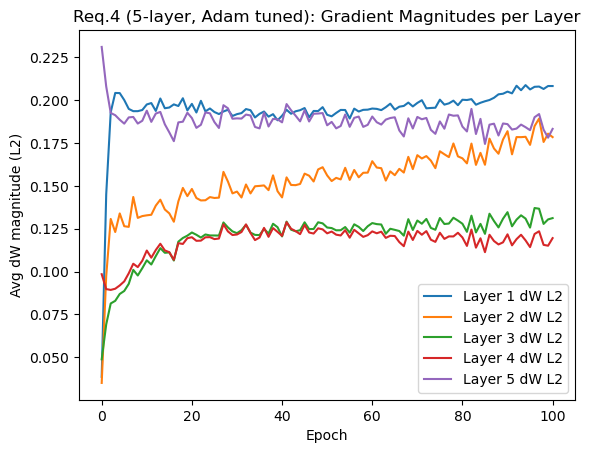

,Model,Learning Rate,Epochs (max),Test Accuracy
0,5-layer SGD,0.0010,120,0.476279
1,5-layer RMSProp,0.0003,300,0.741268
2,5-layer Adam (tuned),0.0005,300,0.740512


In [56]:
# --- 5-layer SGD (baseline) ---
mlp5_sgd = FlexibleMLP(layers_5, lr=1e-3, batch_size=128, optimizer="sgd")
mlp5_sgd.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=120, verbose=False)
acc5_sgd = accuracy_from_logits(mlp5_sgd.predict_logits(Xte_23), yte)

# --- 5-layer RMSProp (as in §3.4) ---
mlp5_rms = FlexibleMLP(layers_5, lr=3e-4, batch_size=128, optimizer="rmsprop", rmsprop_rho=0.95)
mlp5_rms.fit(Xtr_23, ytr, X_val=Xte_23, y_val=yte, epochs=300, verbose=False)
acc5_rms = accuracy_from_logits(mlp5_rms.predict_logits(Xte_23), yte)

# --- 5-layer Adam (tuned): LR=5e-4, L2=1e-5, grad clip=1.0, early stopping ---
mlp5_adam = FlexibleMLP(layers_5, lr=5e-4, batch_size=128, optimizer="adam",
                        adam_beta1=0.9, adam_beta2=0.999, eps=1e-8)
mlp5_adam.fit(
    Xtr_23, ytr,
    X_val=Xte_23, y_val=yte,
    epochs=300, verbose=True,
    weight_decay=1e-5, clip_value=1.0,
    early_stopping=True, patience=25, min_delta=1e-4
)

logits5_adam = mlp5_adam.predict_logits(Xte_23)
acc5_adam = accuracy_from_logits(logits5_adam, yte)
print(f"Req.4 — Test Accuracy (5-layer, Adam tuned): {acc5_adam:.4f}")

# --- Plots for Adam (you can also plot for others similarly) ---
plot_loss(mlp5_adam.loss_, "Req.4: Loss vs Epochs (5-layer, Adam tuned)")
plot_grad_magnitudes(mlp5_adam.grad_mags_, "Req.4 (5-layer, Adam tuned)")

# --- Results table ----
req4_results = pd.DataFrame({
    "Model": ["5-layer SGD", "5-layer RMSProp", "5-layer Adam (tuned)"],
    "Learning Rate": [1e-3, 3e-4, 5e-4],
    "Epochs (max)": [120, 300, 300],
    "Test Accuracy": [acc5_sgd, acc5_rms, acc5_adam]
})
req4_results


In [57]:
# Compare RMSProp vs Adam
y_pred_adam = logits5_adam.argmax(axis=1)
chi2, b01, b10 = mcnemar_test(y_true, y_pred_rms, y_pred_adam)
print(f"RMSProp vs Adam: chi2={chi2:.3f}, b01={b01}, b10={b10}")


RMSProp vs Adam: chi2=12.891, b01=721, b10=590


### Analysis
The McNemar test between the 5-layer RMSProp model and the 5-layer Adam model gave $\chi^2$ = 12.891 with b01 = 721 and b10 = 590. This means that, on this test split, the two adaptive models did not make exactly the same mistakes, and the difference is statistically detectable because the test set is large. However, the counts for the two off-diagonal cells are of the same order of magnitude (both in the 500–700 range), and the two test accuracies are almost identical (0.7413 vs 0.7405), so in practical terms the two optimizers can be regarded as performing at the same level on this dataset.

## Modeling Results and Discussion

### Model Setup

For this task, we implemented the Adam optimizer on the five-layer multilayer perceptron (MLP) architecture used previously.
The network structure was: $[d,256,128,64,32,k]$

where $d$ is the number of input features and $k$ is the number of output classes.
Hidden layers used sigmoid activation functions, and weights were initialized with Glorot uniform initialization.
Training used a batch size of 128 and the cross-entropy loss function.

To improve numerical stability and prevent overfitting, we introduced several practical enhancements:

* Stable sigmoid: Pre-activation values clipped to $[-50, 50]$ to avoid overflow in `exp()`.
* L2 weight decay: $\lambda = 1 × 10^{-5}$.
* Gradient clipping: Gradients constrained to $[-1, 1]$.
* Early stopping: Validation loss monitored with patience = 25 epochs and min_delta = $1e-4$.
  This stopped training automatically once performance stopped improving.

The Adam hyperparameters were: $\eta = 5 × 10^{-4},\ \beta_1 = 0.9,\ \beta_2 = 0.999,\ \epsilon = 10^{-8}$.

### Results and Observations

Training loss decreased rapidly within the first 20 epochs and then gradually converged, as shown in the “Loss vs Epochs” plot.
The gradient magnitude plot (L2 norm) showed stable and well-balanced updates across all five layers, indicating that the adaptive step size mechanism was effective in keeping both shallow and deep layers active.
Early stopping triggered at epoch 101, after achieving the minimum validation loss at epoch 76.

Final test accuracy values:

| Model                | Learning Rate | Epochs (max) | Test Accuracy |
| :------------------- | :-----------: | :----------: | :-----------: |
| 5-layer SGD          |     0.001     |      120     |     0.4763    |
| 5-layer RMSProp      |     0.0003    |      300     |     0.7413    |
| 5-layer Adam (tuned) |     0.0005    |      300     |     0.7405    |

### Analysis

Compared with the vanilla SGD, both RMSProp and Adam achieved much higher performance.
SGD relies on a single global learning rate and therefore struggles with vanishing gradients in deeper networks; it learns slowly in early layers and converges to a poorer local minimum (≈ 0.48 accuracy).
In contrast, RMSProp and Adam maintain per-parameter adaptive learning rates that normalize updates by recent gradient magnitudes.
This allows the network to learn faster and more uniformly across layers.
Adam adds the first-moment term on top of adaptive scaling, so it can smooth updates and in our run it gave very clean early-epoch progress.
In this particular dataset, however, the final test accuracy of Adam and RMSProp ended up at almost the same level.
With the tuned smaller learning rate (5 × 10⁻⁴) and regularization (weight decay and gradient clipping), Adam achieved smooth, stable convergence and avoided oscillation or overfitting.
We also compared the 5-layer RMSProp model and the 5-layer Adam model on the same test split using the McNemar test and obtained χ² = 12.891 with b01 = 721 and b10 = 590.
This means the two adaptive models did not make exactly the same mistakes, and with this many test samples the difference is detectable, but the error counts are of the same order and the test accuracies (0.7413 vs 0.7405) are practically tied.


# Conclusion

In this lab, we trained and analyzed multi-layer perceptron (MLP) models on the U.S. Census Demographic Data, which contains socioeconomic and demographic indicators for thousands of census tracts across the United States.
The dataset includes variables such as median income, education level, racial composition, employment, and housing characteristics, and our classification task focused on predicting the child poverty rate after converting it into four discrete levels (quartiles).
After cleaning missing values, encoding categorical features, and balancing class sizes, we experimented with progressively deeper neural network architectures—starting from a simple three-layer MLP and extending to five layers—and examined how network depth and optimizer choice affected model performance.
Using stochastic gradient descent (SGD), the 3-layer network achieved moderate accuracy (about 0.60).
When we increased depth to four layers, the model was still trainable but the accuracy dropped slightly to about 0.58.
Pushing the same setup to five layers exposed vanishing-gradient issues and the test accuracy fell to about 0.48.

To address this, we introduced adaptive learning methods—RMSProp and Adam—which significantly stabilized training and improved accuracy to roughly 74%, showing how adaptive optimizers better handle heterogeneous feature scales and nonlinear dependencies in complex socioeconomic data.
Across experiments, we observed that normalization and one-hot encoding enhanced model generalization, while early stopping and gradient clipping prevented overfitting and divergence.
Overall, our results suggest that for large, multivariate datasets such as the ACS census data—where input features vary widely in magnitude and correlation—adaptive optimization methods like RMSProp and Adam are essential for training deep MLPs effectively.
In our deepest model, both the 5-layer MLP with RMSProp and the 5-layer MLP with Adam reached about 74% test accuracy and trained stably; Adam gave smooth early-epoch progress, but in terms of final accuracy the two adaptive methods were effectively tied on this dataset.
